## Paintings Artistic Style Recognition using CNN

In [1]:
import os, cv2, re
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('TkAgg')
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.applications.vgg19 import VGG19
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.regularizers import *

Using TensorFlow backend.


### Importing Image Dataset

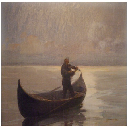

In [2]:
img_width = 128
img_height = 128
TRAIN_DIR = 'art_fulldata/images/'
TEST_DIR = 'art_fulldata/test_data/'
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

#plotting train_images[1]
content_image = Image.open(train_images[0])
content_image = content_image.resize((img_height, img_width))
content_image

In [3]:
len(train_images)

9692

### Preparing Data

In [4]:
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    for i in list_of_images:
        try:
            x.append(cv2.resize(cv2.imread(i), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
            if 'Abstract' in i:
                y.append(1)
            elif 'Baroque' in i:
                y.append(2)
            elif 'Renaissance' in i:
                y.append(3)
            elif 'Impressionism' in i:
                y.append(4)
            elif 'NeoClassical' in i:
                y.append(5)
            elif 'Oriental' in i:
                y.append(6)
            elif 'Realism' in i:
                y.append(7)
            elif 'Rococo' in i:
                y.append(8)
            elif 'Romantic' in i:
                y.append(9)
            elif 'ukiyoe' in i:
                y.append(10)
            elif 'Modern' or 'Pop' in i:
                y.append(11)
        except:
            continue        
    return x, y

#X, Y = prepare_data(train_images[1:80]) #used for testing
X, Y = prepare_data(train_images)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.5)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

channels_last


### CNN Baseline Model

In [5]:
# select optimizer and hyperparams
optimizer = optimizers.Adadelta()
model = models.Sequential()

model.add(layers.Conv2D(64, (5, 5), input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (5, 5)))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 64)      4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
__________

### CNN Model With Transfer Learning

In [9]:
Input_1 = Input(shape=(img_width, img_height, 3), name='Input_1')
VGG19_4_model = VGG19(include_top= False, input_tensor = Input_1)
VGG19_4 = VGG19_4_model(Input_1)
num_layers = len(VGG19_4_model.layers)
for i, layer in enumerate(VGG19_4_model.layers):
    if ((i * 100) / (num_layers - 1)) <= (100 - 0):
        layer.trainable = False
        
Convolution2D_21 = Convolution2D(name='Convolution2D_21',nb_col= 5,nb_filter= 64,border_mode= 'same' ,activation= 'hard_sigmoid' ,nb_row= 5)(VGG19_4)
MaxPooling2D_1 = MaxPooling2D(name='MaxPooling2D_1',border_mode= 'same' )(Convolution2D_21)
LeakyReLU_3 = LeakyReLU(name='LeakyReLU_3')(MaxPooling2D_1)

Convolution2D_3 = Convolution2D(name='Convolution2D_3',nb_col= 5,nb_filter= 64,border_mode= 'same' ,activation= 'relu' ,nb_row= 5)(LeakyReLU_3)
MaxPooling2D_2 = MaxPooling2D(name='MaxPooling2D_2',border_mode= 'same' )(Convolution2D_3)
LeakyReLU_1 = LeakyReLU(name='LeakyReLU_1')(MaxPooling2D_2)

Convolution2D_17 = Convolution2D(name='Convolution2D_17',nb_col= 3,nb_filter= 128,border_mode= 'same' ,activation= 'hard_sigmoid' ,nb_row= 3)(LeakyReLU_1)
MaxPooling2D_3 = MaxPooling2D(name='MaxPooling2D_3',border_mode= 'same' )(Convolution2D_17)
LeakyReLU_2 = LeakyReLU(name='LeakyReLU_2')(MaxPooling2D_3)

GlobalAveragePooling2D_1 = GlobalAveragePooling2D(name='GlobalAveragePooling2D_1')(LeakyReLU_2)
Dense_46 = Dense(name='Dense_46',output_dim= 64)(GlobalAveragePooling2D_1)
Dropout_2 = Dropout(name='Dropout_2',p= 0.3)(Dense_46)
Dense_28 = Dense(name='Dense_28',output_dim= 12,activation= 'softmax' )(Dropout_2)

model = Model([Input_1],[Dense_28])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
Convolution2D_21 (Conv2D)    (None, 4, 4, 64)          819264    
_________________________________________________________________
MaxPooling2D_1 (MaxPooling2D (None, 2, 2, 64)          0         
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 2, 2, 64)          0         
_________________________________________________________________
Convolution2D_3 (Conv2D)     (None, 2, 2, 64)          102464    
_________________________________________________________________
MaxPooling2D_2 (MaxPooling2D (None, 1, 1, 64)          0         
__________

/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="Convolution2D_21", activation="hard_sigmoid", kernel_size=(5, 5), filters=64, padding="same")`
  
/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(name="MaxPooling2D_1", padding="same")`
  if __name__ == '__main__':
/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="Convolution2D_3", activation="relu", kernel_size=(5, 5), filters=64, padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/Users/home/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(name="MaxPooling2D_2", padding="same")`
  i

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

X_train = np.array(X_train)
history = model.fit(X_train, Y_train,
    epochs=10, verbose=1, #turn to 0 for no text
    batch_size = 32)

Epoch 1/10
4845/4845 [==============================] - 1135s 234ms/step - loss: 1.5251 - acc: 0.4436
Epoch 2/10
4845/4845 [==============================] - 1103s 228ms/step - loss: 1.2107 - acc: 0.5705
Epoch 3/10
4845/4845 [==============================] - 1247s 257ms/step - loss: 1.0933 - acc: 0.6056
Epoch 4/10
4845/4845 [==============================] - 1217s 251ms/step - loss: 0.9850 - acc: 0.6392
Epoch 5/10
4845/4845 [==============================] - 1223s 252ms/step - loss: 0.8780 - acc: 0.6852
Epoch 6/10
4845/4845 [==============================] - 1226s 253ms/step - loss: 0.7863 - acc: 0.7205
Epoch 7/10
2624/4845 [===============>..............] - ETA: 47:02 - loss: 0.6848 - acc: 0.7603

### Analysing Results

In [7]:
#Plotting Loss/Acc
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['acc'], label="accuracy")
plt.title("Evolution of neural net on training set")
plt.legend()
plt.show()

In [ ]:
#Plotting Confusion Matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_pred))
plt.show()

### Saving Trained Model

In [ ]:
from keras.models import load_model
#import h5py

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model
# load model as new variable
model = load_model('my_model.h5')